In [5]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from typing import Tuple, Union, List
import matplotlib.pyplot as plt

random_state = 88844
rng = np.random.default_rng(seed=random_state)

data = load_breast_cancer()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]
target_names = data["target_names"]

print(X.shape, y.shape)
print("Target classes:", target_names)


(569, 30) (569,)
Target classes: ['malignant' 'benign']


# Baseline model

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, log_loss

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
print(f"X_train size: {X_train.shape}")
print(f"X_test size: {X_test.shape}")

pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

pipe.fit(X_train, y_train)

y_test_preds = pipe.predict(X_test)

print(classification_report(y_test, y_test_preds))


X_train size: (455, 30)
X_test size: (114, 30)
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.97      0.99      0.98        69

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



# Implementing the same model using `flower`

## Ingredients:
1. Split the data into $n$ datasets, each representing a different location where the data lives
2. Define functions for:
    - Getting model parameters
    - Setting model parameters
3. Define `FlowerClient` 
    - Should contain the following:
        - `get_parameters`
        - `fit`
        - `evaluate`
4. Set Federated learning strategy
6. Simulate!

## 1. Data setup
Since we have ~450 training instances, let's say we have $n=5$ different hospitals where the breast cancer data lives

In [7]:
def split_dataset(
    X: np.array, y: np.array, n_clients: int = 5
) -> List[Tuple[np.array, np.array]]:
    n_clients = 5
    partition_sizes = len(X) // n_clients

    partition_indices = rng.choice(
        len(X), size=(n_clients, partition_sizes), replace=False
    )
    sets = [(X[pidx], y[pidx]) for pidx in partition_indices]
    return sets


train_sets = split_dataset(X_train, y_train)
train_sets[0][0].shape, train_sets[0][1].shape  # Number of samples for our first client



((91, 30), (91,))

We'll have a single test set shared across all clients

In [8]:
test_set = (X_test, y_test)

## 2. Fetching/reloading model parameters
Taken from the `flower` [sklearn example](https://github.com/adap/flower/blob/main/examples/sklearn-logreg-mnist/utils.py)

**Notes:**
- `get_model_params` needs to return a list of parameters
    - It doesn't seem to allow for List of Lists of different sizes (i.e. ragged arrays)
    - such lists throw an error when fitting
- `set_initial_params` initializes the StdScaler and LogReg parameters to random values
    - An alternative approach would be to fit the model on a dummy dataset that has the same shape as the training data


In [9]:
from sklearn.pipeline import Pipeline

def get_model_parameters(pipe: Pipeline) -> dict:
    params = [
        pipe[0].scale_, pipe[0].mean_, pipe[0].var_,
        pipe[1].coef_
    ]
       
    if pipe[1].fit_intercept:
        params.append(pipe[1].intercept_)

    return params


def set_model_params(pipe: Pipeline, params) -> Pipeline:
    """Since we're working wiht a pipeline object, we need to set
    the parameters for all underlying models. In this case a scaler and LogisticRegression.
    """
    # unpack scaler parameters
    pipe[0].scale_, pipe[0].mean_, pipe[0].var_ = params[:3]

    if pipe[1].fit_intercept:
        pipe[1].coef_, pipe[1].intercept_ = params[3:]
    else:
        pipe[1].coef_ = params[-1]
    return pipe


def set_initial_params(pipe: Pipeline, n_feats, n_classes=1) -> Pipeline:   
    pipe[0].scale_ = rng.random(size=(n_feats))
    pipe[0].mean_ = rng.random(size=(n_feats))
    pipe[0].var_ = rng.random(size=(n_feats))
    pipe[0].n_samples_seen_ = rng.random(size=(n_feats))


    pipe[1].classes_ = np.arange(n_classes)
    pipe[1].coef_ = rng.random(size=(n_classes, n_feats))
    if pipe[1].fit_intercept:
        pipe[1].intercept_ = rng.random(size=(n_classes))
    # return pipe

## 3. Define FlowerClient

In [25]:
import pickle
import warnings
import flwr as fl

class BreastCancerClient(fl.client.NumPyClient):
    def __init__(self, cid, pipe, train_set, test_set):
        self.cid = cid
        self.pipe = pipe
        self.clf = self.pipe.steps[-1][1]
        self.X_train, self.y_train = train_set
        self.X_test, self.y_test = test_set

    def get_parameters(self, config):
        return get_model_parameters(self.pipe)

    def fit(self, parameters, config):
        set_model_params(self.pipe, parameters)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.pipe.fit(self.X_train, self.y_train)

        # Save each model for investigation later
        print(f"Training finished for round {config['server_round']}")
        with open(f"../models/client/client_{self.cid}_rnd_{config['server_round']}.pkl" , "wb") as client_f:
            pickle.dump(self.pipe, client_f)

        return self.get_parameters(self.pipe), len(self.X_train), {}

    def evaluate(self, parameters, config):  # type: ignore
        set_model_params(self.pipe, parameters)
        loss = log_loss(self.y_test, self.clf.predict_proba(self.X_test))
        accuracy = self.clf.score(self.X_test, self.y_test)

        print(f"Evaluation finished for round {config['server_round']}")
        return loss, len(self.X_test), {"accuracy": accuracy}

def launch_client(client_id, train_sets=train_sets, test_set=test_set):
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1, warm_start=True))
    train_set = train_sets[int(client_id)]
    set_initial_params(model, n_feats=(train_set[0][0].shape[-1]), n_classes=1)
    return BreastCancerClient(client_id, model, train_set, test_set)

## 5. Set Federated learning strategy


To keep track of the client side accuracy, we implement a `mean_accuracy` function.

The `metrics` input to this function is a list of the form: `[(n_examples, dict(metric_name, value))]`, where `n_examples` is the number of examples seen by the client in a training round.

In [30]:
from flwr.common import Metrics

# Implement function to print weighted mean accuracy across clients
def weighted_accuracy(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

def evaluate(server_round, parameters, config):
    """Evaluation function to compute centralized accuracy"""
    model = pipe
    set_model_params(model, parameters)
    loss = log_loss(y_test, model[1].predict_proba(X_test))
    accuracy = model.score(X_test, y_test)
    
    print(f"Centralized evaluation finished for round {server_round}")

    # Save each model for investigation later
    with open(f"../models/server/pipeline_rnd_{server_round}.pkl" , "wb") as server_f:
        pickle.dump(model, server_f)
    return loss, {"accuracy": accuracy}

def fit_config(server_round: int) -> dict:
    return {"server_round": server_round}

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,
    min_evaluate_clients=1,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_accuracy,
    evaluate_fn=evaluate,
    on_fit_config_fn=fit_config,
    on_evaluate_config_fn=fit_config
)

## 6. Simulate!

In [31]:
n_rounds = 5

hist = fl.simulation.start_simulation(
    client_fn=launch_client,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=n_rounds),
    strategy=strategy,
    client_resources=None
)

INFO flwr 2023-04-30 17:07:18,140 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-30 17:07:22,798	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-04-30 17:07:25,567 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 11812164404.0, 'object_store_memory': 5906082201.0, 'CPU': 24.0, 'GPU': 1.0}
INFO flwr 2023-04-30 17:07:25,568 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-30 17:07:25,569 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-04-30 17:07:26,220 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-04-30 17:07:26,221 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-30 17:07:26,225 | server.py:91 | initial parameters (loss, other metrics): 14.227757916756769, {'accuracy': 0.6052631578947368}
INFO flwr 2023-04-30 17:07:26,226 | server.py:101 | FL starting
DEBUG 

Centralized evaluation finished for round 0
(launch_and_fit pid=5204) Training finished for round 1


DEBUG flwr 2023-04-30 17:07:26,998 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-30 17:07:27,003 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-04-30 17:07:27,010 | server.py:119 | fit progress: (1, 21.815895472360378, {'accuracy': 0.9385964912280702}, 0.7831496999999672)
DEBUG flwr 2023-04-30 17:07:27,010 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-04-30 17:07:27,025 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
DEBUG flwr 2023-04-30 17:07:27,026 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 5)
DEBUG flwr 2023-04-30 17:07:27,045 | server.py:232 | fit_round 2 received 5 results and 0 failures
INFO flwr 2023-04-30 17:07:27,055 | server.py:119 | fit progress: (2, 21.815895472360378, {'accuracy': 0.9649122807017544}, 0.8279682999998386)
DEBUG flwr 2023-04-30 17:07:27,055 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out 

Centralized evaluation finished for round 1
Centralized evaluation finished for round 2
Centralized evaluation finished for round 3
(launch_and_evaluate pid=5204) Evaluation finished for round 2
Centralized evaluation finished for round 4
Centralized evaluation finished for round 5


INFO flwr 2023-04-30 17:07:27,198 | server.py:147 | FL finished in 0.9714344999999867
INFO flwr 2023-04-30 17:07:27,199 | app.py:218 | app_fit: losses_distributed [(1, 21.815895472360378), (2, 21.815895472360378), (3, 21.815895472360378), (4, 21.815895472360378), (5, 21.815895472360378)]
INFO flwr 2023-04-30 17:07:27,200 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-04-30 17:07:27,201 | app.py:220 | app_fit: metrics_distributed {'accuracy': [(1, 0.39473684210526316), (2, 0.39473684210526316), (3, 0.39473684210526316), (4, 0.39473684210526316), (5, 0.39473684210526316)]}
INFO flwr 2023-04-30 17:07:27,201 | app.py:221 | app_fit: losses_centralized [(0, 14.227757916756769), (1, 21.815895472360378), (2, 21.815895472360378), (3, 21.815895472360378), (4, 21.815895472360378), (5, 21.815895472360378)]
INFO flwr 2023-04-30 17:07:27,203 | app.py:222 | app_fit: metrics_centralized {'accuracy': [(0, 0.6052631578947368), (1, 0.9385964912280702), (2, 0.9649122807017544), (3, 0.97

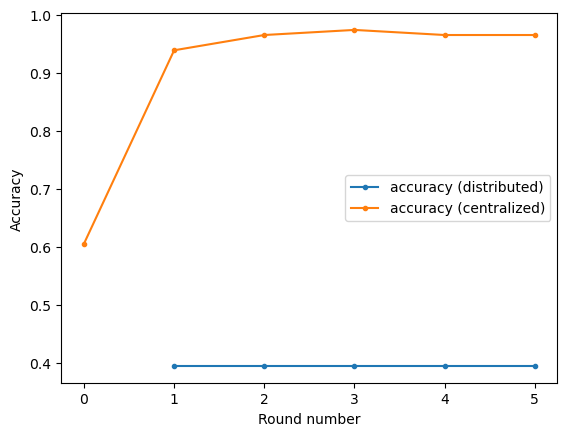

In [33]:
dist_acc = [acc for round_n, acc in hist.metrics_distributed["accuracy"]]
centr_acc = [acc for round_n, acc in hist.metrics_centralized["accuracy"]]

plt.plot(range(1, n_rounds+1), dist_acc, ".-", label="accuracy (distributed)")
plt.plot(range(0, n_rounds+1), centr_acc, ".-", label="accuracy (centralized)") # Centralized metrics have a first evaluation done with the initial weights
plt.legend()
plt.xlabel("Round number")
plt.ylabel("Accuracy")
plt.show()


# 7. Looking at the models for each round

The distributed accuracies are not changing across rounds. I believe this is due to the same model being fit with the same dataset for each client. Since there's little data and the algorithm for fitting LogisticRegression is fairly efficient, it is likely that it quickly attains the optimum value.

Let's evaluate each client model on the full training dataset at each round to see what kind of performance we'll have. (We expect good performance on the instances for each model's partition, but each other partition is unseen, and so it serves as a good way to test the models).

In [49]:
import os
import re

models_fpath = "../models/"
client_fpaths = [os.path.join(models_fpath, "client", fname) for fname in  os.listdir(os.path.join(models_fpath, "client"))]

client_models = {}
for fpath in client_fpaths:
    client_id, round_n = re.findall("\d", fpath)
    if f"client_{client_id}" not in client_models:
        client_models[f"client_{client_id}"] = {}

    with open(fpath, "rb") as f:
        client_models[f"client_{client_id}"][f"round_{round_n}"] = pickle.load(f)

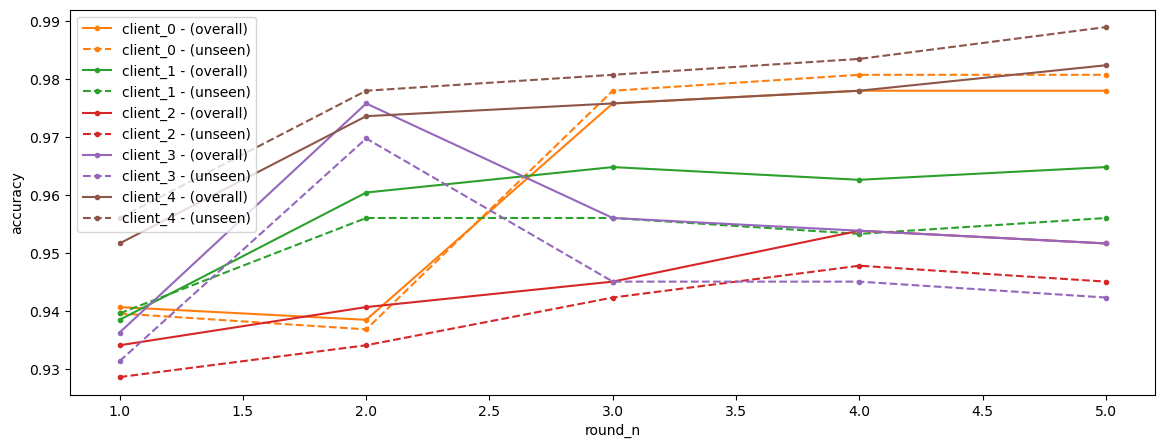

In [119]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)
cmap = mpl.colormaps.get_cmap("tab10")


for client_id, round_models in client_models.items():

    unseen_X_train = np.concatenate([X for idx, (X, y) in enumerate(train_sets) if idx != int(client_id[-1])])
    unseen_y_train = np.concatenate([y for idx, (X, y) in enumerate(train_sets) if idx != int(client_id[-1])])
    all_acc = [model.score(X_train, y_train) for model in round_models.values()]
    unseen_acc = [model.score(unseen_X_train, unseen_y_train) for model in round_models.values()]
    c = cmap(int(client_id[-1])+1)
    ax.plot(range(1, n_rounds+1), all_acc, ".-", label=f"{client_id} - (overall)", c=c)
    ax.plot(range(1, n_rounds+1), unseen_acc, ".--", label=f"{client_id} - (unseen)", c=c)
    
ax.set_xlabel("round_n")
ax.set_ylabel("accuracy")
plt.legend()
plt.show()


Interesting to note that for 2 of the clients, the unseen accuracy was higher than the overall accuracy.